# Market Regime Modeling - v1.0

https://lucid.app/lucidchart/1d1da6ad-2f5b-404e-a2e0-5fc09d555908/edit?view_items=sDP_6P2O9gUE&invitationId=inv_f6dfc2ff-a89c-4265-bff5-bedbb0340d49

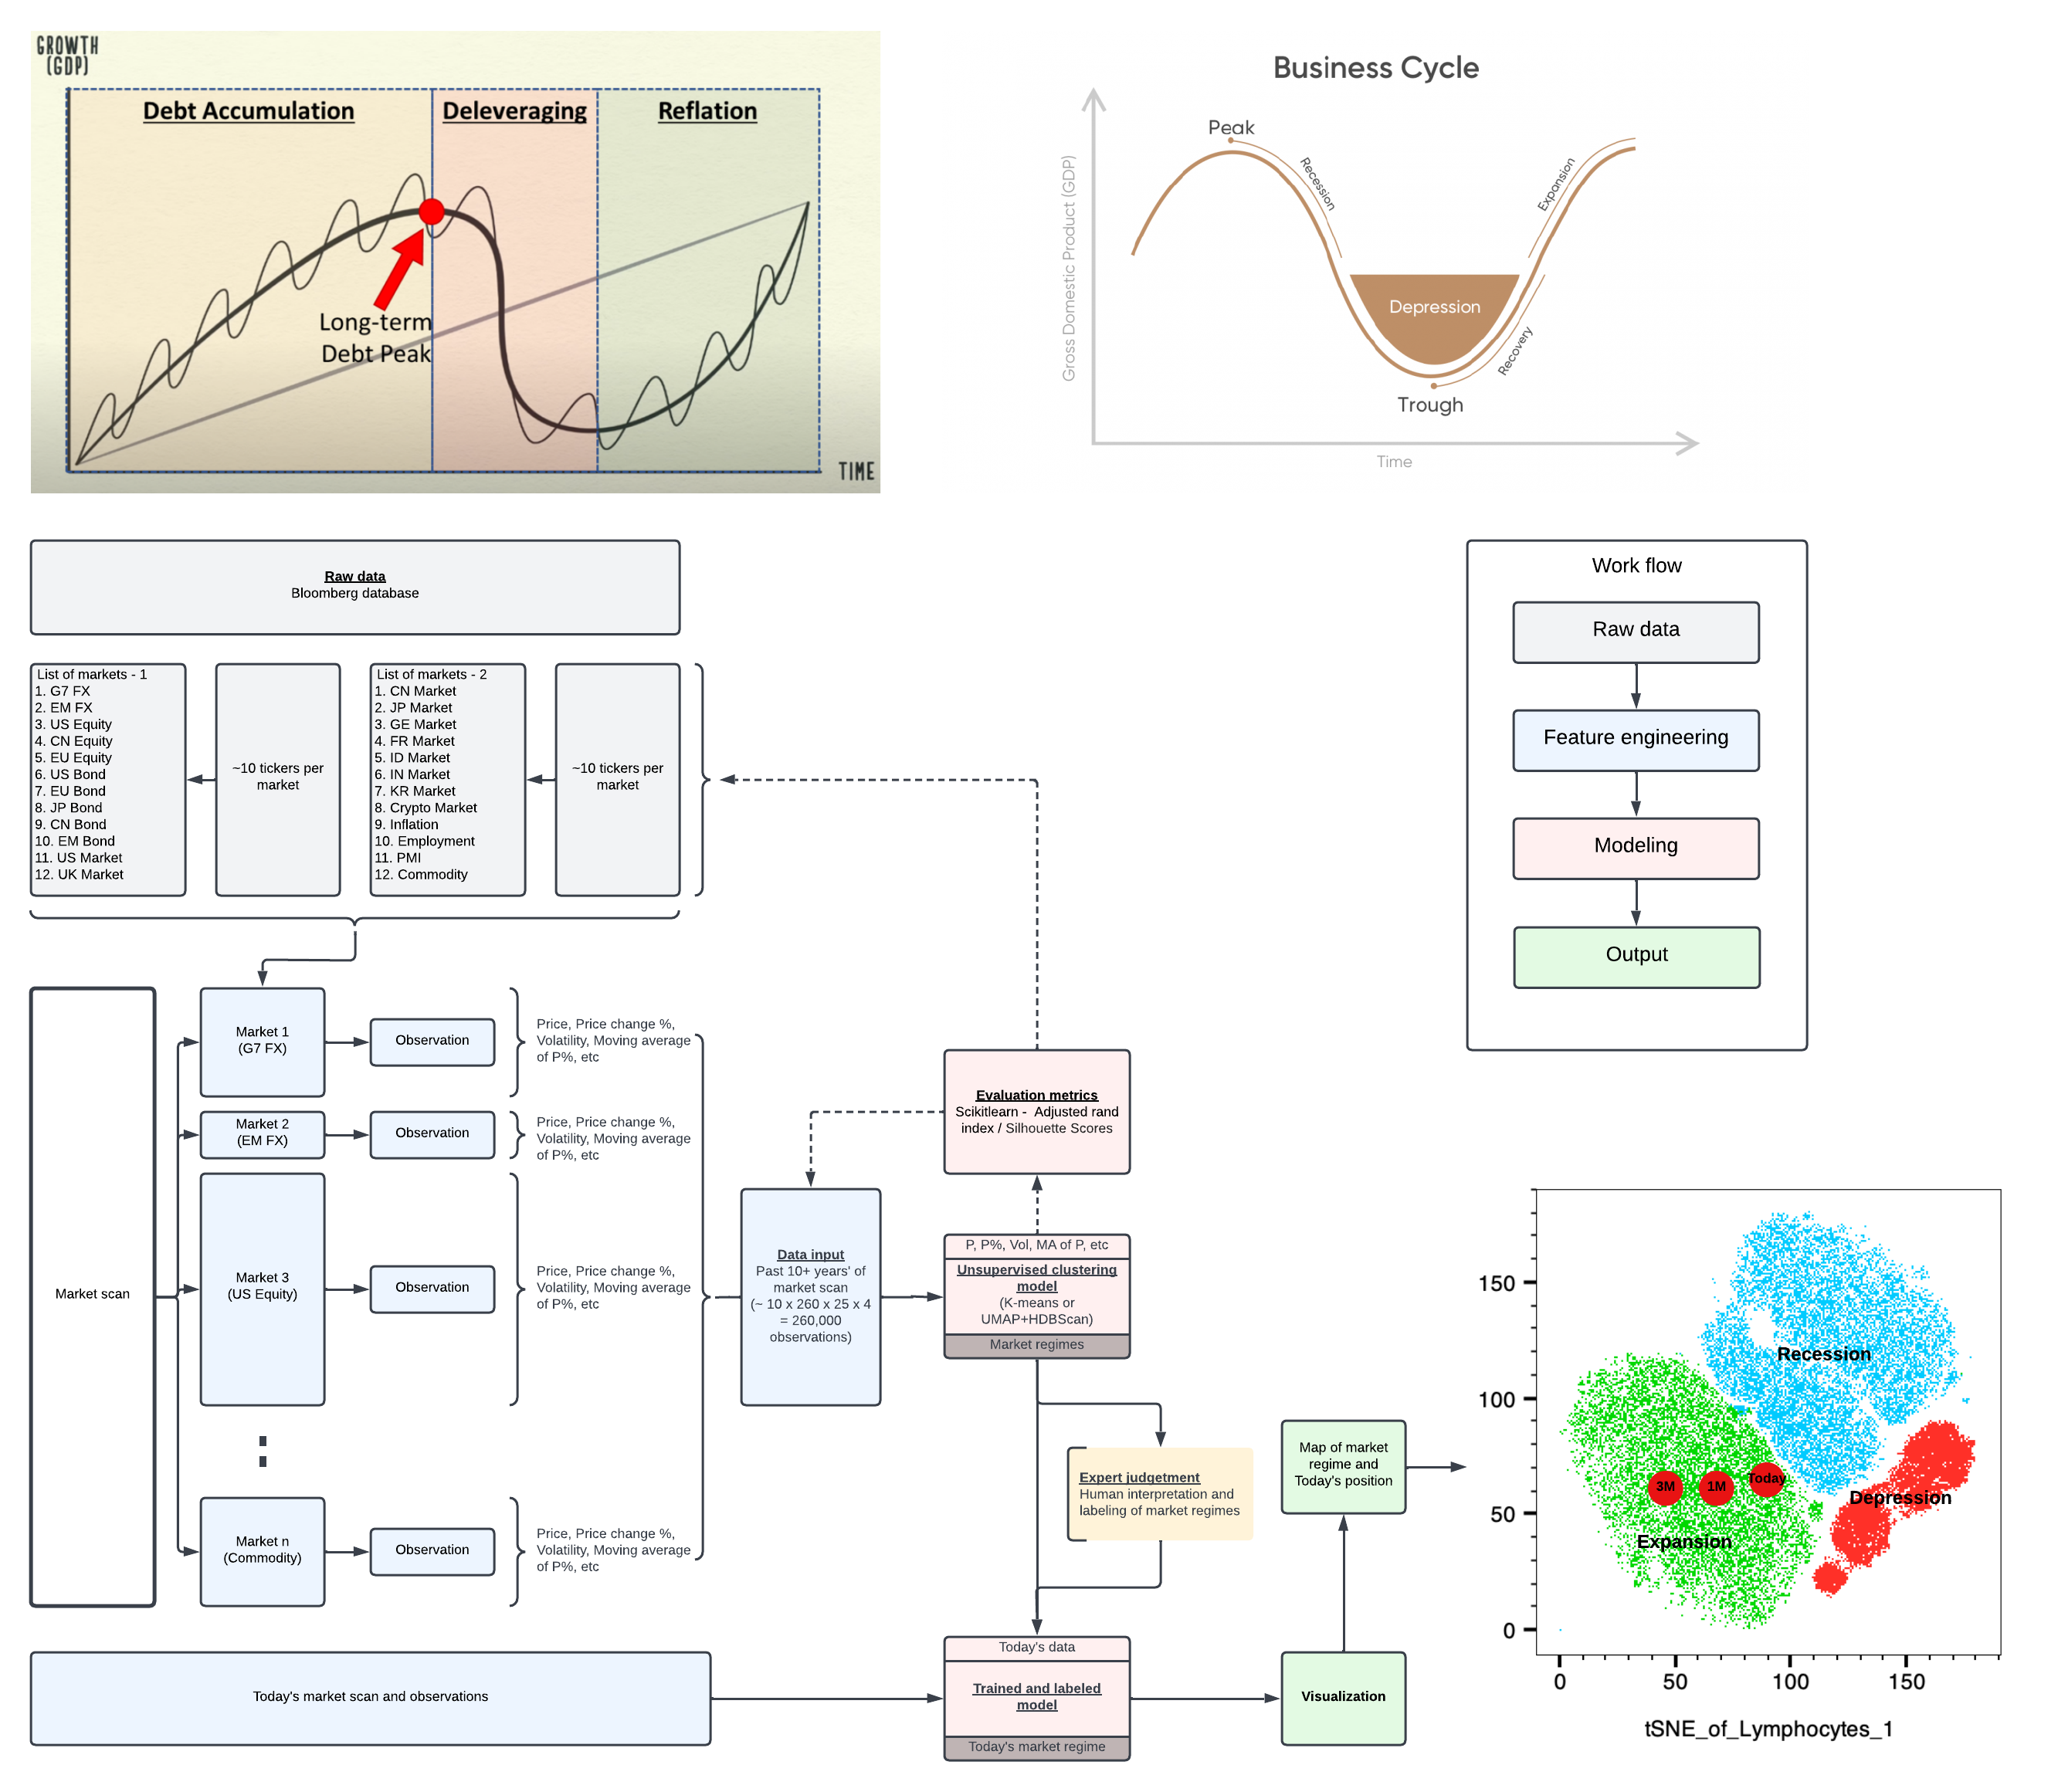

In [2]:
# Libraries
import os
import pandas as pd
import numpy as np

#plot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

# 1.Data Preparation

## Variables

In [8]:
# variables

base_index = "XAU Curncy" # Gold
# Base_index = "EUCRBRDT Index" # Crude oil

li_rolling_window = [
    10, # 2W
    21, # 1M
    42, # 2M
    65, # 3M
    ]
li_calculation_type = [
    "MA",
    "STD",
    "DIFF",
    ]

start_date = None
end_date = None

## Data loading and preprocessing

In [9]:
# Load dataset
dir = os.getcwd()
raw_data = pd.read_csv(os.path.join(dir,"INPUT/index_data.csv"))

# Convert date to datetime format from 8/2/23 to 2023-08-02
raw_data['Date'] = pd.to_datetime(raw_data['Date'], format='%d/%m/%y')
raw_data.set_index('Date', inplace=True)

In [10]:
# Data preprocessing - remove error/outliers
raw_data.dropna(axis='columns', inplace=True)

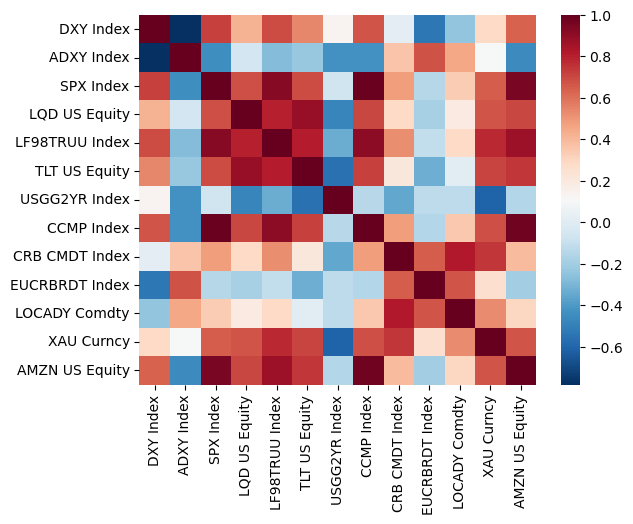

In [12]:
#sns.heatmap(raw_data.corr(),annot=False)
# change color map, cmap = reversed blue red
sns.heatmap(raw_data.corr(),annot=False,cmap='RdBu_r')
plt.show()

In [6]:
ref_data = pd.read_csv(os.path.join(dir,'INPUT/index_set.csv'))
df_index_set = ref_data[ref_data['group']==1][['set','index']]

In [7]:
raw_data.tail()

,DXY Index,ADXY Index,SPX Index,LQD US Equity,LF98TRUU Index,TLT US Equity,USGG2YR Index,CCMP Index,CRB CMDT Index,EUCRBRDT Index,LOCADY Comdty,XAU Curncy,AMZN US Equity
Date,,,,,,,,,,,,,
2023-02-08,103.409,102.46,4117.86,109.44,2276.17,105.56,4.4208,11910.52,553.96,84.56,9006.0,1875.49,100.05
2023-02-09,103.221,102.48,4081.50,108.52,2271.06,104.56,4.4820,11789.58,554.56,83.53,8953.5,1861.78,98.24
2023-02-10,103.630,102.17,4090.46,107.76,2253.47,103.39,4.5170,11718.12,553.72,85.87,8905.0,1865.57,97.61
2023-02-13,103.345,102.02,4137.29,108.16,2255.03,104.26,4.5175,11891.79,553.72,85.22,8912.0,1853.49,99.54
2023-02-14,103.221,102.07,4137.29,108.16,2255.03,104.26,4.5090,11891.79,553.72,85.12,8912.0,1856.01,99.54


In [14]:
df_index_set

,set,index
0,US_equity,SPX Index
1,Asian_currency,ADXY Index
2,US_bond_gov,TLT US Equity
3,US_bond_hg,LQD US Equity
4,Copper,LOCADY Comdty
5,US_rates,USGG2YR Index
6,US_equity_AMZN,AMZN US Equity
7,Crude oil,EUCRBRDT Index


## Feature engineering

In [8]:
# raw_data: raw data, with index = Date

def preprocessing_scaler(raw_data, base_index):
    scaled_data = raw_data.div(raw_data.iloc[0], axis=1) # Divide by the first row to normalize the starting point to 1
    scaled_data = scaled_data.div(scaled_data.loc[:, base_index], axis=0) # Divide by Base price to neutralize the effect of inflation
    
    return scaled_data

def select_period(raw_data, start_date, end_date):

    #sort by date
    raw_data = raw_data.sort_index()

    if start_date == None:
        start_date = raw_data.index[0]
    if end_date == None:
        end_date = raw_data.index[-1]
   
    return raw_data.loc[start_date:end_date]

def group_data(raw_data,df_index_set):

    # select columns from raw data where column name is in index set['index']
    df_selected = raw_data[df_index_set['index']]

    # caculate the mean value of columns if columns are in the same set
    li_set = df_index_set['set'].unique()
    for set in li_set:
        df_selected[set] = df_selected[df_index_set[df_index_set['set'] == set]['index']].mean(axis=1)
    
    df_grouped = df_selected[li_set]

    return df_grouped

In [9]:
def round_to_n_levels(values,n): # round values into n levels from 0 to 1

    values = (values-values.min())/(values.max()- values.min()) # normalize
    values = (values * n).round(0) / n # round to n levels
    return values

def construct_market_data(df_raw, li_rolling_window, li_calculation_type,rounded = True, round_level = 8):
    df_derived = pd.DataFrame()  # Create an empty DataFrame to store derived values

    for col in df_raw.columns:
        for rolling_window in li_rolling_window:
            col_data = df_raw[col]  # Extract the column data to improve readability

            if "MA" in li_calculation_type:
                ma_col_name = f'{col}_MA{rolling_window}'
                ma_values = col_data - col_data.rolling(window=rolling_window).mean()
                df_derived[ma_col_name] = (ma_values > 0).astype(int)  # Convert boolean to 0 or 1

            if "STD" in li_calculation_type:
                std_col_name = f'{col}_STD{rolling_window}'
                std_values = col_data.rolling(window=rolling_window).std() / col_data.rolling(window=rolling_window).mean()
                if rounded:
                    df_derived[std_col_name] = round_to_n_levels(values = std_values,n =round_level)
                

            if "DIFF" in li_calculation_type:
                diff_col_name = f'{col}_DIFF{rolling_window}'
                diff_values = col_data.diff(rolling_window)
                df_derived[diff_col_name] = (diff_values > 0).astype(int)  # Convert boolean to 0 or 1

    # Drop rows with missing values
    df_derived.dropna(axis=0, how='any', inplace=True)

    return df_derived


In [11]:
#ignore warining
import warnings
warnings.filterwarnings('ignore')

df_scaled = preprocessing_scaler(raw_data, base_index)
df_period = select_period(df_scaled,start_date,end_date)
df_grouped = group_data(df_period,df_index_set)
df_derived = construct_market_data(df_grouped,li_rolling_window,li_calculation_type)

In [12]:
df_derived.tail(5)

,US_equity_MA10,US_equity_STD10,US_equity_DIFF10,US_equity_MA21,US_equity_STD21,US_equity_DIFF21,US_equity_MA42,US_equity_STD42,US_equity_DIFF42,US_equity_MA65,...,Crude oil_DIFF10,Crude oil_MA21,Crude oil_STD21,Crude oil_DIFF21,Crude oil_MA42,Crude oil_STD42,Crude oil_DIFF42,Crude oil_MA65,Crude oil_STD65,Crude oil_DIFF65
Date,,,,,,,,,,,,,,,,,,,,,
2023-02-08,1,0.250,1,1,0.25,1,1,0.125,0,1,...,1,1,0.000,1,1,0.000,1,0,0.125,0
2023-02-09,1,0.250,1,1,0.25,1,1,0.125,0,1,...,0,1,0.000,1,1,0.000,1,0,0.125,0
2023-02-10,1,0.250,1,1,0.25,1,1,0.125,0,1,...,1,1,0.000,1,1,0.000,1,1,0.125,0
2023-02-13,1,0.125,1,1,0.25,1,1,0.125,1,1,...,1,1,0.000,1,1,0.000,1,1,0.125,0
2023-02-14,1,0.125,1,1,0.25,1,1,0.125,1,1,...,1,1,0.125,1,1,0.125,1,1,0.125,0


In [ ]:
# data download
df_derived.to_csv(os.path.join(dir,'INPUT/market_data.csv'))

# 2. Data Analyisis

## Load processed data

In [3]:
# load data
dir = os.getcwd()
df_derived = pd.read_csv(os.path.join(dir,'INPUT/market_data.csv'), index_col=0)

In [4]:
market_data_PCA = df_derived.copy()
#select columns that do NOT start with 'US_equity_AMZN'
market_data = df_derived.loc[:,~df_derived.columns.str.startswith('US_equity_AMZN')]

## PCA

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

market_data_transformed = StandardScaler().fit_transform(market_data_PCA)
pca = PCA()
principalComponents = pca.fit_transform(market_data_transformed)

principalDf = pd.DataFrame(data = principalComponents, columns=market_data_PCA.columns)
Ranking_PC0 = abs(principalDf.iloc[0,:])
Ranking_PC0.sort_values(ascending=False, inplace=True)

Ranking_PC1 = abs(principalDf.iloc[1,:])
Ranking_PC1.sort_values(ascending=False, inplace=True)

print('PC0 ranking')
print(Ranking_PC0[:10])
print()


print('PC1 ranking')
print(Ranking_PC1[:10])
print()
pca.explained_variance_ratio_.round(2)

PC0 ranking
US_equity_DIFF21        3.439008
US_equity_STD10         2.974205
US_equity_MA42          2.829485
US_equity_STD21         2.338100
US_equity_MA21          2.151221
US_bond_gov_MA10        1.925415
Asian_currency_STD10    1.900906
Asian_currency_STD21    1.894926
Asian_currency_MA21     1.416927
US_bond_hg_STD65        1.386495
Name: 0, dtype: float64

PC1 ranking
US_equity_MA10          3.646182
US_equity_STD21         3.301785
US_equity_MA42          3.215805
Asian_currency_MA21     2.862342
US_equity_MA65          2.230058
US_equity_MA21          1.460180
US_equity_STD65         1.405146
Asian_currency_MA10     1.396538
Asian_currency_MA42     1.375423
Asian_currency_STD10    1.347247
Name: 1, dtype: float64



array([0.19, 0.13, 0.07, 0.05, 0.04, 0.04, 0.04, 0.03, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

# 3. Model

## Variable

In [5]:
market_model = "UMAP"
N_neighbors = 30
N_clusters = 9
N_dimensions = 2

## dimension reduce: UMAP, TSNE

In [6]:
# Model libraries
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import umap

In [8]:
def embedding(reducer_name, dimension, neighbor, market_data):
    if reducer_name == "TSNE":
        clusterable_embedding = TSNE(
        n_components=dimension,
        perplexity=neighbor,
        ).fit_transform(market_data)
    elif reducer_name == "UMAP":
        clusterable_embedding = umap.UMAP(
        n_components=dimension,
        n_neighbors=neighbor,
        min_dist=0.0,
        ).fit_transform(market_data)
    else:
        print("Unidentified model")

    return clusterable_embedding

In [9]:
clusterable_embedding = embedding(reducer_name = 'UMAP', dimension=N_dimensions, neighbor=N_neighbors, market_data=market_data)

## K means

In [18]:
kmeans = KMeans(
    init="random",
    n_clusters=N_clusters,
    n_init=30,
    max_iter=300,
    )
# visualizer = KElbowVisualizer(kmeans, k=(2,10))
# visualizer.fit(clusterable_embedding)
# visualizer.show()

labels_KMEANS = kmeans.fit_predict(clusterable_embedding)

In [19]:
# add labels to the data
labels = labels_KMEANS
df_labeled = market_data.copy()
df_labeled['label'] = labels

In [20]:
# rename the labels by statistics of each cluster

def rename_labels(df_labeled, index_col):

    # rename lablels: rank of mean of US_equity_MA65 in each kmeans cluster(label) 
    df_summary = df_labeled.groupby("label")[index_col].describe()
    df_summary['relabel'] = df_summary['mean'].rank(ascending= False).astype(int)

    # add column 'relabel' to df_labeled
    df_labeled = df_labeled.merge(df_summary['relabel'], on='label', how='left')

    return df_labeled

In [21]:
df_labeled = rename_labels(df_labeled, "US_equity_MA65")
df_labeled

,US_equity_MA10,US_equity_STD10,US_equity_DIFF10,US_equity_MA21,US_equity_STD21,US_equity_DIFF21,US_equity_MA42,US_equity_STD42,US_equity_DIFF42,US_equity_MA65,...,Crude oil_STD21,Crude oil_DIFF21,Crude oil_MA42,Crude oil_STD42,Crude oil_DIFF42,Crude oil_MA65,Crude oil_STD65,Crude oil_DIFF65,label,relabel
0,0,0.125,0,0,0.125,0,0,0.125,1,0,...,0.125,1,1,0.125,1,1,0.125,0,6,7
1,1,0.125,1,1,0.125,0,0,0.125,1,1,...,0.125,1,1,0.125,1,1,0.125,1,4,2
2,1,0.125,1,1,0.125,0,0,0.125,1,1,...,0.125,1,1,0.125,1,1,0.125,1,4,2
3,1,0.125,1,1,0.125,1,1,0.125,1,1,...,0.125,1,1,0.125,1,1,0.125,1,4,2
4,1,0.125,1,1,0.125,1,1,0.125,1,1,...,0.125,1,1,0.125,1,1,0.125,1,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4594,1,0.250,1,1,0.250,1,1,0.125,0,1,...,0.000,1,1,0.000,1,0,0.125,0,5,6
4595,1,0.250,1,1,0.250,1,1,0.125,0,1,...,0.000,1,1,0.000,1,0,0.125,0,5,6
4596,1,0.250,1,1,0.250,1,1,0.125,0,1,...,0.000,1,1,0.000,1,1,0.125,0,5,6
4597,1,0.125,1,1,0.250,1,1,0.125,1,1,...,0.000,1,1,0.000,1,1,0.125,0,4,2


In [22]:
# Calculate summary statistics for "US_equity_MA65" grouped by "ranking"
df_labeled.groupby("relabel")["US_equity_MA65"].describe()

,count,mean,std,min,25%,50%,75%,max
relabel,,,,,,,,
1,407.0,0.990172,0.098769,0.0,1.0,1.0,1.0,1.0
2,501.0,0.986028,0.117492,0.0,1.0,1.0,1.0,1.0
3,397.0,0.957179,0.202709,0.0,1.0,1.0,1.0,1.0
4,560.0,0.910714,0.285411,0.0,1.0,1.0,1.0,1.0
5,617.0,0.661264,0.473664,0.0,0.0,1.0,1.0,1.0
6,456.0,0.326754,0.469542,0.0,0.0,0.0,1.0,1.0
7,432.0,0.185185,0.388898,0.0,0.0,0.0,0.0,1.0
8,516.0,0.067829,0.251697,0.0,0.0,0.0,0.0,1.0
9,713.0,0.057504,0.232966,0.0,0.0,0.0,0.0,1.0


# Visualization

In [37]:
points = np.array(df_labeled['relabel'])

colors = points
weights = np.full_like(points, fill_value=20)
opacities = np.full_like(points, fill_value=1)/4

# Hightlight the last point
colors[-1] = -1 # set the darkest color for this point
weights[-1] = 80 # set a larger size value for this point
opacities[-1] = 1 # set a higher opacity value for this point

In [38]:
if N_dimensions == 2:
    fig = px.scatter(
        clusterable_embedding,
        x=0, y=1,
        title='2D_plot',
        color=colors,
        size=weights,
        height=700,
        width=700,
        opacity=opacities,
        )
    fig.update_traces(
        marker=dict(
            line=dict(width=0,color='DarkSlateGrey')),
            selector=dict(mode='markers')
            )
    fig.show()

elif N_dimensions == 3:
    fig = px.scatter_3d(
        clusterable_embedding,
        x=0, y=1, z=2,
        title='3D_plot',
        color = colors,
        size=weights,
        height=700,
        width=700,
        opacity=opacities,
        )
    fig.update_traces(
        marker=dict(
            line=dict(width=0,color='DarkSlateGrey')),
            selector=dict(mode='markers')
            )
    fig.show()

else:
    pass

# Prediction and Evaluation - Naive Bayes

In [39]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

nb = CategoricalNB()

In [30]:
def naive_bayes(window_period, relabels_KMEANS_copy, nb):
    Transition_table = pd.DataFrame(relabels_KMEANS_copy, columns=['T']) # create a column T as Today's label
    Transition_table['Last_median_03'] = Transition_table['T'].shift(1).rolling(window=3).median() # compute the median of the previous 3 days
    Transition_table['Last_median_10'] = Transition_table['T'].shift(1).rolling(window=10).median() # compute the median of the previous 10 days
    Transition_table['Last_median_'+str(window_period)] = Transition_table['T'].shift(1).rolling(window=window_period).median() # compute the median of the previous window period
    # Transition_table['Last_mean_'+str(window_period)] = Transition_table['T'].shift(1).rolling(window=window_period).mean().round(0) # compute the mean of the previous window period
    Transition_table['Last_max_'+str(window_period)] = Transition_table['T'].shift(1).rolling(window=window_period).max() # compute the max of the previous window period
    Transition_table['Last_min_'+str(window_period)] = Transition_table['T'].shift(1).rolling(window=window_period).min() # compute the min of the previous window period
    Transition_table_processed = Transition_table.iloc[window_period+1:,:] # remove NA rows

    nb.fit(Transition_table_processed.loc[:, Transition_table_processed.columns!='T'].values,Transition_table_processed['T'].values) # fit the NB function

    Last_row = Transition_table_processed.loc[:, Transition_table_processed.columns!='T']
    Last_row = Last_row.iloc[-1] # get today's value

    return nb.predict_proba([Last_row]).round(2)[0] # make prediction

In [31]:
def generate_labels(Market_data_copy, Query_item):
    Summary = Market_data_copy.groupby("label")[Query_item].describe()
    Summary = Summary.sort_values(by=['mean'])
    Summary.insert(0, 'relabel_equity', range(0, len(Summary)))
    Mapping_table = dict(zip(Summary.index, Summary["relabel_equity"]))
    relabels = Market_data_copy["label"].map(Mapping_table)
    Market_data_copy["ranking"] = relabels
    return Market_data_copy

In [32]:
def naive_bayes_eval(window_period, relabels_KMEANS_copy, nb):
    Transition_table = pd.DataFrame(relabels_KMEANS_copy, columns=['T']) # create a column T as Today's label
    Transition_table['Last_median_03'] = Transition_table['T'].shift(1).rolling(window=3).median() # compute the median of the previous 3 days
    Transition_table['Last_median_10'] = Transition_table['T'].shift(1).rolling(window=10).median() # compute the median of the previous 10 days
    Transition_table['Last_median_'+str(window_period)] = Transition_table['T'].shift(1).rolling(window=window_period).median() # compute the median of the previous window period
    # Transition_table['Last_mean_'+str(window_period)] = Transition_table['T'].shift(1).rolling(window=window_period).mean().round(0) # compute the mean of the previous window period
    Transition_table['Last_max_'+str(window_period)] = Transition_table['T'].shift(1).rolling(window=window_period).max() # compute the max of the previous window period
    Transition_table['Last_min_'+str(window_period)] = Transition_table['T'].shift(1).rolling(window=window_period).min() # compute the min of the previous window period
    Transition_table_processed = Transition_table.iloc[window_period+1:,:] # remove NA rows

    X = Transition_table_processed.drop(['T'], axis=1)
    y = Transition_table_processed['T']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

    nb.fit(X_train, y_train)
    y_pred = nb.predict(X_test)

    return accuracy_score(y_test, y_pred)

In [33]:
def display(Market_data_copy, Monitor_period):
    for Query_item in Query_list:
        Market_data_copy = generate_labels(Market_data_copy, Query_item)

        fig = px.area(
        Market_data_copy[-Monitor_period:],
        x=Market_data_copy[-Monitor_period:].index,
        y=Market_data_copy[-Monitor_period:]["ranking"],
        labels=dict(x="Date", y="Cycle stages"),
        title=Query_item,
        height=350, width=500,
        )
        fig.show()

        Summary_table = Market_data_copy.groupby("ranking")[Query_item].describe()
        relabels_ranking = list(Market_data_copy["ranking"])

        # Bayes model probability
        n = 0
        for window_period in range(20, 500):
            if window_period % 10 == 0:
                if n == 0:
                    res_0 = naive_bayes(window_period, relabels_ranking, nb)
                    res_1 = res_0
                else:
                    res_0 = naive_bayes(window_period, relabels_ranking, nb)
                    res_1 = np.add(res_0, res_1)
                n = n + 1

        res = np.round(res_1/n, 3)
        res = pd.DataFrame(res)

        fig = px.bar(
        res,
        height=300, width=500,
        text_auto=True,
        )
        fig.show()

        print(Summary_table.round(2)) # mean column is the chance of market rally

        Summary_table['Chance'] = res
        Summary_table['Equity_rally_odds'] = Summary_table['mean'] * Summary_table['Chance']
        Summary_table['Equity_rally_STD'] = Summary_table['std'] * Summary_table['Chance']

        print()
        print('Chance of rally in '+Query_item)
        Mean = Summary_table.Equity_rally_odds.sum().round(3)
        print(Mean)
        print('Standard deviation')
        Std = Summary_table.Equity_rally_STD.sum().round(3)
        print(Std)

        # Bayes model evaluation

        # n = 0
        # for window_period in range(20, 500):
        #     if window_period % 10 == 0:
        #         if n == 0:
        #             acc_0 = naive_bayes_eval(window_period, relabels_ranking, nb)
        #             acc_1 = acc_0
        #         else:
        #             acc_0 = naive_bayes_eval(window_period, relabels_ranking, nb)
        #             acc_1 = np.add(acc_0, acc_1)
        #         n = n + 1

        # acc = np.round(acc_1/n, 3)
        # print('Model accuracy')
        # print(acc)
        # print()

In [34]:
Query_list = Market_set.columns+"_MA21" # query every item in the market set with 3 months trend
Monitor_period = 600

# Display

In [35]:
display(Market_data_copy, Monitor_period=Monitor_period)

         count  mean   std  min  25%  50%  75%  max
ranking                                            
0        600.0  0.18  0.39  0.0  0.0  0.0  0.0  1.0
1        507.0  0.21  0.41  0.0  0.0  0.0  0.0  1.0
2        417.0  0.31  0.46  0.0  0.0  0.0  1.0  1.0
3        587.0  0.42  0.49  0.0  0.0  0.0  1.0  1.0
4        579.0  0.66  0.47  0.0  0.0  1.0  1.0  1.0
5        464.0  0.74  0.44  0.0  0.0  1.0  1.0  1.0
6        380.0  0.82  0.39  0.0  1.0  1.0  1.0  1.0
7        447.0  0.89  0.32  0.0  1.0  1.0  1.0  1.0
8        422.0  0.93  0.25  0.0  1.0  1.0  1.0  1.0

Chance of rally in US_equity_MA21
0.726
Standard deviation
0.435


         count  mean   std  min  25%  50%  75%  max
ranking                                            
0        600.0  0.04  0.18  0.0  0.0  0.0  0.0  1.0
1        417.0  0.12  0.33  0.0  0.0  0.0  0.0  1.0
2        587.0  0.15  0.36  0.0  0.0  0.0  0.0  1.0
3        507.0  0.22  0.42  0.0  0.0  0.0  0.0  1.0
4        579.0  0.64  0.48  0.0  0.0  1.0  1.0  1.0
5        447.0  0.69  0.46  0.0  0.0  1.0  1.0  1.0
6        380.0  0.73  0.44  0.0  0.0  1.0  1.0  1.0
7        464.0  0.81  0.39  0.0  1.0  1.0  1.0  1.0
8        422.0  0.89  0.31  0.0  1.0  1.0  1.0  1.0

Chance of rally in Asian_currency_MA21
0.802
Standard deviation
0.386


         count  mean   std  min  25%  50%  75%  max
ranking                                            
0        600.0  0.07  0.26  0.0  0.0  0.0  0.0  1.0
1        587.0  0.08  0.27  0.0  0.0  0.0  0.0  1.0
2        417.0  0.12  0.33  0.0  0.0  0.0  0.0  1.0
3        447.0  0.26  0.44  0.0  0.0  0.0  1.0  1.0
4        464.0  0.63  0.48  0.0  0.0  1.0  1.0  1.0
5        579.0  0.68  0.47  0.0  0.0  1.0  1.0  1.0
6        507.0  0.79  0.41  0.0  1.0  1.0  1.0  1.0
7        422.0  0.85  0.35  0.0  1.0  1.0  1.0  1.0
8        380.0  0.86  0.35  0.0  1.0  1.0  1.0  1.0

Chance of rally in US_bond_gov_MA21
0.612
Standard deviation
0.476


         count  mean   std  min  25%  50%  75%  max
ranking                                            
0        600.0  0.02  0.16  0.0  0.0  0.0  0.0  1.0
1        587.0  0.06  0.25  0.0  0.0  0.0  0.0  1.0
2        417.0  0.10  0.30  0.0  0.0  0.0  0.0  1.0
3        507.0  0.39  0.49  0.0  0.0  0.0  1.0  1.0
4        447.0  0.59  0.49  0.0  0.0  1.0  1.0  1.0
5        579.0  0.65  0.48  0.0  0.0  1.0  1.0  1.0
6        464.0  0.72  0.45  0.0  0.0  1.0  1.0  1.0
7        380.0  0.87  0.34  0.0  1.0  1.0  1.0  1.0
8        422.0  0.87  0.34  0.0  1.0  1.0  1.0  1.0

Chance of rally in US_bond_hg_MA21
0.705
Standard deviation
0.448


         count  mean   std  min  25%  50%  75%  max
ranking                                            
0        507.0  0.10  0.30  0.0  0.0  0.0  0.0  1.0
1        600.0  0.14  0.35  0.0  0.0  0.0  0.0  1.0
2        464.0  0.47  0.50  0.0  0.0  0.0  1.0  1.0
3        587.0  0.50  0.50  0.0  0.0  1.0  1.0  1.0
4        579.0  0.51  0.50  0.0  0.0  1.0  1.0  1.0
5        380.0  0.63  0.48  0.0  0.0  1.0  1.0  1.0
6        422.0  0.71  0.45  0.0  0.0  1.0  1.0  1.0
7        447.0  0.84  0.37  0.0  1.0  1.0  1.0  1.0
8        417.0  0.85  0.35  0.0  1.0  1.0  1.0  1.0

Chance of rally in Copper_MA21
0.471
Standard deviation
0.493


         count  mean   std  min  25%  50%  75%  max
ranking                                            
0        507.0  0.06  0.24  0.0  0.0  0.0  0.0  1.0
1        417.0  0.12  0.33  0.0  0.0  0.0  0.0  1.0
2        600.0  0.16  0.37  0.0  0.0  0.0  0.0  1.0
3        380.0  0.34  0.47  0.0  0.0  0.0  1.0  1.0
4        579.0  0.66  0.47  0.0  0.0  1.0  1.0  1.0
5        587.0  0.67  0.47  0.0  0.0  1.0  1.0  1.0
6        447.0  0.77  0.42  0.0  1.0  1.0  1.0  1.0
7        464.0  0.77  0.42  0.0  1.0  1.0  1.0  1.0
8        422.0  0.86  0.34  0.0  1.0  1.0  1.0  1.0

Chance of rally in US_rates_MA21
0.765
Standard deviation
0.416


         count  mean   std  min  25%  50%  75%  max
ranking                                            
0        507.0  0.36  0.48  0.0  0.0  0.0  1.0  1.0
1        600.0  0.44  0.50  0.0  0.0  0.0  1.0  1.0
2        417.0  0.45  0.50  0.0  0.0  0.0  1.0  1.0
3        587.0  0.48  0.50  0.0  0.0  0.0  1.0  1.0
4        579.0  0.59  0.49  0.0  0.0  1.0  1.0  1.0
5        464.0  0.67  0.47  0.0  0.0  1.0  1.0  1.0
6        380.0  0.71  0.45  0.0  0.0  1.0  1.0  1.0
7        447.0  0.74  0.44  0.0  0.0  1.0  1.0  1.0
8        422.0  0.81  0.39  0.0  1.0  1.0  1.0  1.0

Chance of rally in US_equity_AMZN_MA21
0.665
Standard deviation
0.468


         count  mean   std  min  25%  50%  75%  max
ranking                                            
0        507.0  0.11  0.32  0.0  0.0  0.0  0.0  1.0
1        579.0  0.14  0.35  0.0  0.0  0.0  0.0  1.0
2        600.0  0.39  0.49  0.0  0.0  0.0  1.0  1.0
3        417.0  0.53  0.50  0.0  0.0  1.0  1.0  1.0
4        464.0  0.57  0.50  0.0  0.0  1.0  1.0  1.0
5        587.0  0.72  0.45  0.0  0.0  1.0  1.0  1.0
6        380.0  0.76  0.43  0.0  1.0  1.0  1.0  1.0
7        447.0  0.84  0.37  0.0  1.0  1.0  1.0  1.0
8        422.0  0.89  0.32  0.0  1.0  1.0  1.0  1.0

Chance of rally in Crude oil_MA21
0.573
Standard deviation
0.491


In [ ]:
11111
